In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

#### One-hot encoding

In [2]:
def one_hot_encoding(y, numOfClasses):
    """
    Converts label into one-hot encoding.
    takes in the labels and the number of classes 
    """
    encoded = np.zeros((y.shape[0],numOfClasses))
    for i in range(y.shape[0]):
        encoded[i][y[i]] = 1.0
    return encoded

#### load the data

In [3]:
train_data = pd.read_csv('./ex4_train.csv', index_col="Unnamed: 0")
test_data = pd.read_csv('./ex4_test.csv', index_col="Unnamed: 0")

#### Split the data into X and y

In [4]:
X_train = train_data.iloc[:, train_data.columns != 'y']
y_train = train_data["y"].values.reshape(-1,1)
X_test = test_data.iloc[:, test_data.columns != 'y']
y_test = test_data["y"].values.reshape(-1,1)

X_train_array = np.asarray(X_train)
y_train_array = np.asarray(y_train)
X_test_array = np.asarray(X_test)
y_test_array = np.asarray(y_test)

#### One-hot encode the labels

In [5]:
y_train_encoded = one_hot_encoding(y_train_array, 10)
y_test_encoded = one_hot_encoding(y_test_array, 10)

#### Network architecture

In [6]:
input_layer_size = 400
hidden_layer1_size = 150
hidden_layer2_size = 100
output_layer_size = 10

In [7]:
epochs = 1000
learning_rate = 0.01

In [8]:
def createPlaceholders(input_layer_size, hidden_layer1_size, hidden_layer2_size, output_layer_size):
    tf.set_random_seed(10)
    #Declare placeholders
    x = tf.placeholder(tf.float32, [None, input_layer_size])
    y = tf.placeholder(tf.float32, [None, output_layer_size])
    
    #Declare keep probability placeholder
    keep_prob = tf.placeholder("float")
    
    return x, y, keep_prob

def xavierWeightInitializer(input_layer_size, hidden_layer1_size, hidden_layer2_size, output_layer_size):
    tf.set_random_seed(10)
    #Initialize weight variables
    w_hidden1 = tf.get_variable('hidden1', shape=[input_layer_size, hidden_layer1_size],\
                                    initializer=tf.contrib.layers.xavier_initializer())
    w_hidden2 = tf.get_variable('hidden2', shape=[hidden_layer1_size, hidden_layer2_size],\
                                    initializer=tf.contrib.layers.xavier_initializer())
    w_output = tf.get_variable('output', shape=[hidden_layer2_size, output_layer_size],\
                                    initializer=tf.contrib.layers.xavier_initializer())

    bias_hidden1 = tf.Variable(tf.zeros([hidden_layer1_size]))
    bias_hidden2 = tf.Variable(tf.zeros([hidden_layer2_size]))
    bias_output = tf.Variable(tf.zeros([output_layer_size]))
    
    return w_hidden1, w_hidden2, w_output, bias_hidden1, bias_hidden2, bias_output

def forwardPropagation(w_hidden1, w_hidden2, w_output, bias_hidden1, bias_hidden2, bias_output, keep_prob):
    tf.set_random_seed(10)
    hiddenLayer1 = tf.add(tf.matmul(x, w_hidden1), bias_hidden1)
    hiddenLayer1 = tf.nn.relu(hiddenLayer1)
    hiddenLayer1 = tf.nn.dropout(hiddenLayer1, keep_prob)
    hiddenLayer2 = tf.add(tf.matmul(hiddenLayer1, w_hidden2), bias_hidden2)
    hiddenLayer2 = tf.nn.relu(hiddenLayer2)
    outputLayer = tf.matmul(hiddenLayer2, w_output) + bias_output
    outputLayer = tf.nn.sigmoid(outputLayer)
    
    return outputLayer

In [9]:
tf.set_random_seed(10)
#create placeholders
x, y, keep_prob = createPlaceholders(input_layer_size, hidden_layer1_size, hidden_layer2_size, output_layer_size)
w_hidden1, w_hidden2, w_output, bias_hidden1, bias_hidden2, bias_output = xavierWeightInitializer(input_layer_size, \
                                                        hidden_layer1_size, hidden_layer2_size, output_layer_size)

output = forwardPropagation(w_hidden1, w_hidden2, w_output, bias_hidden1, bias_hidden2, bias_output, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y))

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [11]:
init = tf.global_variables_initializer()

In [12]:
import time
tf.set_random_seed(10)
train_accuracy = []
test_accuracy = []
keep_probability = np.arange(0.3, 1.0, 0.1)

start_time = time.time()
with tf.Session() as sess:
    # create initialized variables
    sess.run(init)
    for dropout in keep_probability:
        print ("Training using keep probability: ", dropout)
        for epoch in range(epochs):
            _, c = sess.run([optimizer, cost], feed_dict = {x: X_train_array, y: y_train_encoded, keep_prob: dropout})
            if epoch % 100 == 0 and epoch != 0:
                print ("Epoch:", (epoch), "cost =", "{:.5f}".format(c))

        actual_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(actual_prediction, tf.float32))
        accuracy_tr = accuracy.eval({x: X_train_array, y: y_train_encoded, keep_prob: 1.0})
        accuracy_te = accuracy.eval({x: X_test_array, y: y_test_encoded, keep_prob: 1.0})
        train_accuracy.append(accuracy_tr)
        test_accuracy.append(accuracy_te)
        print ("Accuracy on Train Dataset using keep_prob = " + str(dropout) + " :", accuracy_tr)
        print("Accuracy on Test Dataset using keep_prob = " + str(dropout) + " :", accuracy_te)

elapsed_time = time.time() - start_time
print ("Time taken to run: ", float(elapsed_time/60))

Training using keep probability:  0.3
Epoch: 100 cost = 1.50445
Epoch: 200 cost = 1.48438
Epoch: 300 cost = 1.48367
Epoch: 400 cost = 1.47962
Epoch: 500 cost = 1.47746
Epoch: 600 cost = 1.47751
Epoch: 700 cost = 1.48063
Epoch: 800 cost = 1.47577
Epoch: 900 cost = 1.47666
Accuracy on Train Dataset using keep_prob = 0.3 : 0.995143
Accuracy on Test Dataset using keep_prob = 0.3 : 0.939333
Training using keep probability:  0.4
Epoch: 100 cost = 1.46815
Epoch: 200 cost = 1.46662
Epoch: 300 cost = 1.46690
Epoch: 400 cost = 1.46804
Epoch: 500 cost = 1.46789
Epoch: 600 cost = 1.46731
Epoch: 700 cost = 1.46921
Epoch: 800 cost = 1.46690
Epoch: 900 cost = 1.46689
Accuracy on Train Dataset using keep_prob = 0.4 : 0.996286
Accuracy on Test Dataset using keep_prob = 0.4 : 0.940667
Training using keep probability:  0.5
Epoch: 100 cost = 1.46496
Epoch: 200 cost = 1.46502
Epoch: 300 cost = 1.46492
Epoch: 400 cost = 1.46538
Epoch: 500 cost = 1.46530
Epoch: 600 cost = 1.46591
Epoch: 700 cost = 1.46487
Ep

#### Plot of Test accuracy versus keep probability

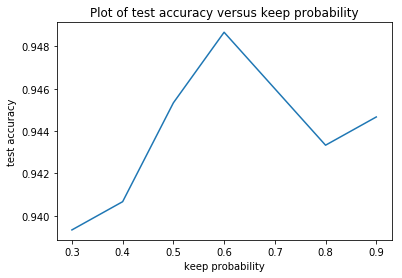

In [13]:
plt.plot(keep_probability, test_accuracy)
plt.xlabel("keep probability")
plt.ylabel("test accuracy")
plt.title("Plot of test accuracy versus keep probability")
plt.show()

#### Plot of Train accuracy versus keep probability

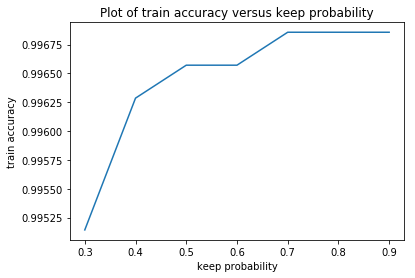

In [14]:
plt.plot(keep_probability, train_accuracy)
plt.xlabel("keep probability")
plt.ylabel("train accuracy")
plt.title("Plot of train accuracy versus keep probability")
plt.show()

In [15]:
max_test_accuracy = max(test_accuracy)
index_max_accuracy = test_accuracy.index(max_test_accuracy)
keep_prob_best = keep_probability[index_max_accuracy]
train_accuracy_final = train_accuracy[index_max_accuracy]

print ("Best accuracy achieved on train dataset: ", train_accuracy_final)
print ("Best accuracy achieved on test dataset: ", max_test_accuracy)

Best accuracy achieved on train dataset:  0.996571
Best accuracy achieved on test dataset:  0.948667
